# Website for EIP-1559 and base fee calculation
https://tokenview.medium.com/how-to-build-a-gas-fee-estimator-for-eip-1559-using-python-2033935d9fd2

In [1]:
import os
import re
from time import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import calendar

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_joined.csv').drop(columns='Unnamed: 0')
df['datetime'] = pd.to_datetime(df['datetime'])

In [3]:
df['gas_used_block_real'] = df['gas_used_block'].shift(-1)
df = df.dropna(subset='gas_used_block_real')
df = df[['block_number', 'avg_receipt_gas_used', 'total_value_transactions',
       'avg_value_transactions', 'datetime', 'size', 'gas_limit',
       'transaction_count', 'gas_used_block', 'Volume', 'Close', 'RSI_adj', 'MACD',
       'MACD_exponential_MA_9', 'Ethereum', 'Solana','gas_used_block_real']]
df = df[df['datetime'] >= '2022-04-08 13:00:00']


In [4]:
df['total_value_transactions'] = df['total_value_transactions'].apply(lambda x: float(x))

In [5]:
df

,block_number,avg_receipt_gas_used,total_value_transactions,avg_value_transactions,datetime,size,gas_limit,transaction_count,gas_used_block,Volume,Close,RSI_adj,MACD,MACD_exponential_MA_9,Ethereum,Solana,gas_used_block_real
629093,14545259,65713.285714,9.046926e+19,3.590050e+17,2022-04-08 13:00:00,210231,30078111,252,16559748,0.0,3229.637939,8.52433,8.635831,11.433631,7.789369e+10,4.024894e+09,28601398.0
629094,14545260,59961.002096,2.602523e+21,5.456024e+18,2022-04-08 13:00:00,155216,30048739,477,28601398,0.0,3229.637939,8.52433,8.635831,11.433631,7.789369e+10,4.024894e+09,3583662.0
629095,14545261,66364.111111,5.925102e+19,1.097241e+18,2022-04-08 13:00:00,21845,30019396,54,3583662,0.0,3229.637939,8.52433,8.635831,11.433631,7.789369e+10,4.024894e+09,2078779.0
629096,14545262,56183.216216,2.439626e+19,6.593585e+17,2022-04-08 13:00:00,12328,30000000,37,2078779,0.0,3229.637939,8.52433,8.635831,11.433631,7.789369e+10,4.024894e+09,14932138.0
629097,14545263,69130.268519,1.443230e+20,6.681619e+17,2022-04-08 13:00:00,78171,30000000,216,14932138,0.0,3229.637939,8.52433,8.635831,11.433631,7.789369e+10,4.024894e+09,9061447.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5213717,19129883,82573.205882,7.445037e+18,1.094858e+17,2024-01-31 23:58:00,28693,30000000,68,5614978,0.0,2282.853760,11.83405,-9.894707,-4.915510,3.121198e+10,1.567440e+09,11343377.0
5213718,19129884,113433.770000,5.914806e+18,5.914806e+16,2024-01-31 23:59:00,54434,30000000,100,11343377,0.0,2282.853760,11.83405,-9.894707,-4.915510,3.121198e+10,1.567440e+09,8910866.0
5213719,19129885,94796.446809,8.268420e+20,8.796191e+18,2024-01-31 23:59:00,51664,30000000,94,8910866,0.0,2282.853760,11.83405,-9.894707,-4.915510,3.121198e+10,1.567440e+09,12392024.0
5213720,19129886,91117.823529,2.864724e+19,2.106415e+17,2024-01-31 23:59:00,210746,30000000,136,12392024,0.0,2282.853760,11.83405,-9.894707,-4.915510,3.121198e+10,1.567440e+09,13179974.0


# Feature engineering and selection trial

In [6]:
df_fe = df.copy()

for i in range(1,5):
    df_fe['gas_used_block_real_pct_' + str(i)] = df_fe['gas_used_block_real'].pct_change(i)
    df_fe['transaction_count_pct_' + str(i)] = df_fe['transaction_count'].pct_change(i)
    for j in range(3,5):
        df_fe['gas_used_block_real_pct_' + str(i) + '_ewm_' + str(j)] = df_fe['gas_used_block_real_pct_' + str(i)].ewm(span=j, adjust=False).mean()
        df_fe['transaction_count_pct_' + str(i) + '_ewm_' + str(j)] = df_fe['transaction_count_pct_' + str(i)].ewm(span=j, adjust=False).mean()


In [7]:
import numpy as np
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import catboost as cb
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.impute import KNNImputer

# Sample data
y = df_fe['gas_used_block_real']
X = df_fe[['avg_receipt_gas_used', 'total_value_transactions',
       'avg_value_transactions', 'size', 'gas_limit',
       'transaction_count', 'gas_used_block', 'Volume', 'Close', 'RSI_adj',
       'MACD', 'MACD_exponential_MA_9', 'Ethereum', 'Solana', 'gas_used_block_real_pct_1',
       'transaction_count_pct_1', 'gas_used_block_real_pct_1_ewm_3',
       'transaction_count_pct_1_ewm_3', 'gas_used_block_real_pct_1_ewm_4',
       'transaction_count_pct_1_ewm_4', 'gas_used_block_real_pct_2',
       'transaction_count_pct_2', 'gas_used_block_real_pct_2_ewm_3',
       'transaction_count_pct_2_ewm_3', 'gas_used_block_real_pct_2_ewm_4',
       'transaction_count_pct_2_ewm_4', 'gas_used_block_real_pct_3',
       'transaction_count_pct_3', 'gas_used_block_real_pct_3_ewm_3',
       'transaction_count_pct_3_ewm_3', 'gas_used_block_real_pct_3_ewm_4',
       'transaction_count_pct_3_ewm_4', 'gas_used_block_real_pct_4',
       'transaction_count_pct_4', 'gas_used_block_real_pct_4_ewm_3',
       'transaction_count_pct_4_ewm_3', 'gas_used_block_real_pct_4_ewm_4',
       'transaction_count_pct_4_ewm_4']]


# XGBoost model
model = cb.CatBoostRegressor()
model.fit(X, y, verbose=False)




Text(0.5, 1.0, 'Feature Importance')

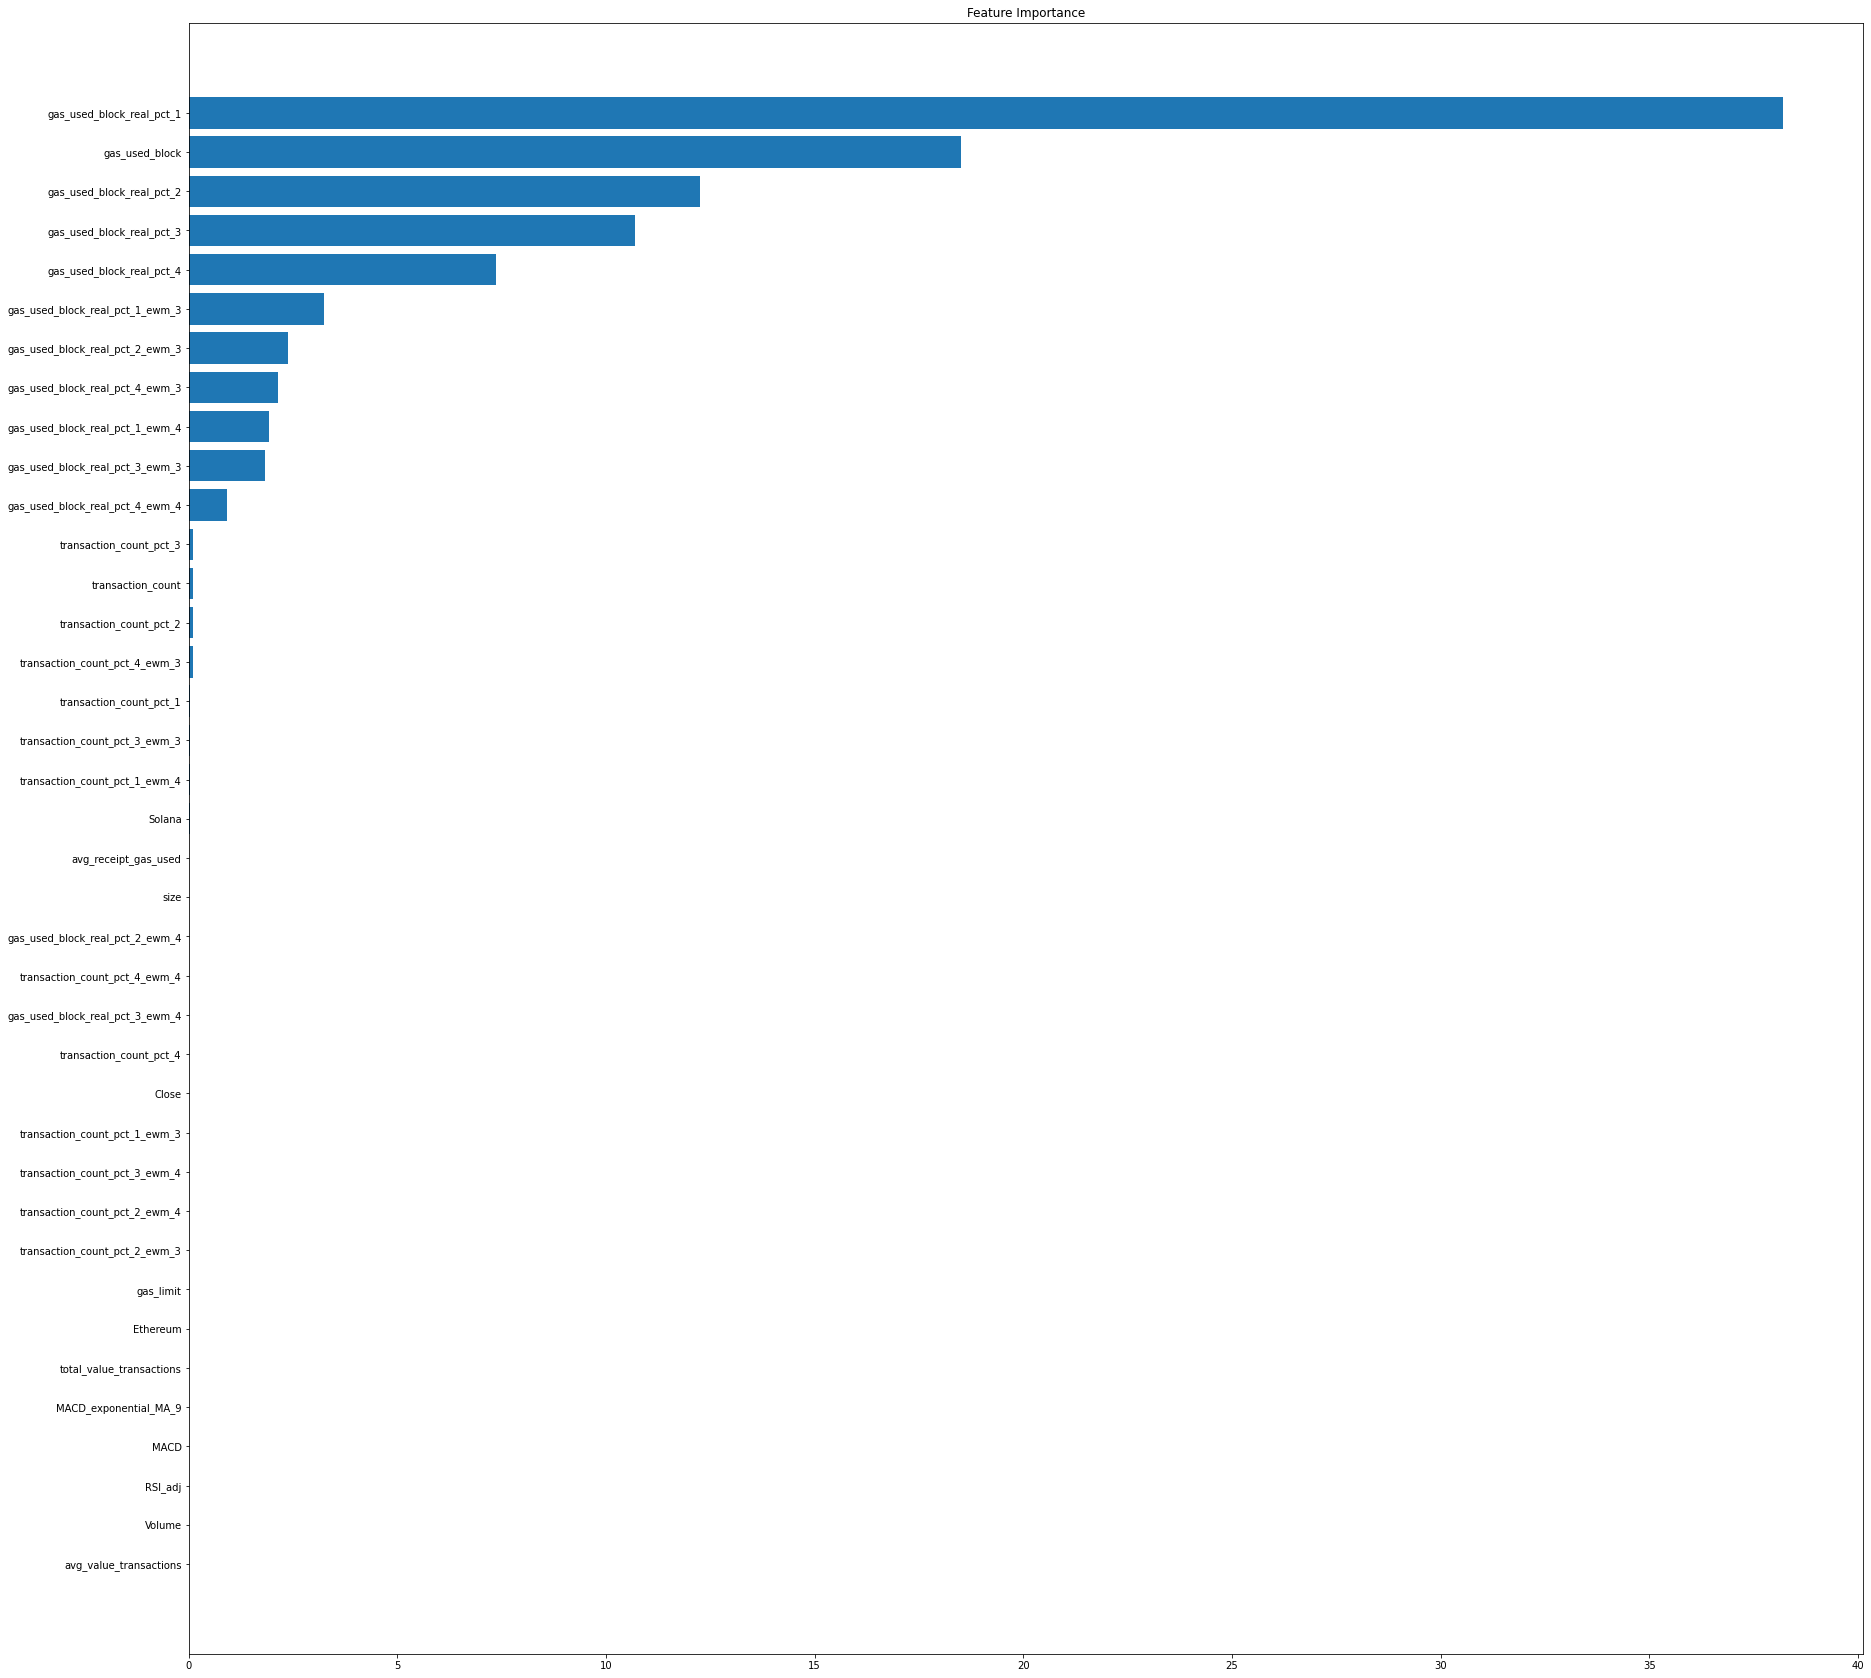

In [8]:

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(30, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')


In [9]:
var_pool = ['avg_receipt_gas_used', 'total_value_transactions',
       'avg_value_transactions', 'size', 'gas_limit',
       'transaction_count', 'gas_used_block', 'Volume', 'Close', 'RSI_adj',
       'MACD', 'MACD_exponential_MA_9', 'Ethereum', 'Solana', 'gas_used_block_real_pct_1',
       'transaction_count_pct_1', 'gas_used_block_real_pct_1_ewm_3',
       'transaction_count_pct_1_ewm_3', 'gas_used_block_real_pct_1_ewm_4',
       'transaction_count_pct_1_ewm_4', 'gas_used_block_real_pct_2',
       'transaction_count_pct_2', 'gas_used_block_real_pct_2_ewm_3',
       'transaction_count_pct_2_ewm_3', 'gas_used_block_real_pct_2_ewm_4',
       'transaction_count_pct_2_ewm_4', 'gas_used_block_real_pct_3',
       'transaction_count_pct_3', 'gas_used_block_real_pct_3_ewm_3',
       'transaction_count_pct_3_ewm_3', 'gas_used_block_real_pct_3_ewm_4',
       'transaction_count_pct_3_ewm_4', 'gas_used_block_real_pct_4',
       'transaction_count_pct_4', 'gas_used_block_real_pct_4_ewm_3',
       'transaction_count_pct_4_ewm_3', 'gas_used_block_real_pct_4_ewm_4',
       'transaction_count_pct_4_ewm_4']
vars_selected = []

for i in range(25):
    cur_var_index = sorted_idx[len(var_pool) - 1 - i]
    vars_selected.append(var_pool[cur_var_index])

In [10]:
vars_selected

['gas_used_block_real_pct_1',
 'gas_used_block',
 'gas_used_block_real_pct_2',
 'gas_used_block_real_pct_3',
 'gas_used_block_real_pct_4',
 'gas_used_block_real_pct_1_ewm_3',
 'gas_used_block_real_pct_2_ewm_3',
 'gas_used_block_real_pct_4_ewm_3',
 'gas_used_block_real_pct_1_ewm_4',
 'gas_used_block_real_pct_3_ewm_3',
 'gas_used_block_real_pct_4_ewm_4',
 'transaction_count_pct_3',
 'transaction_count',
 'transaction_count_pct_2',
 'transaction_count_pct_4_ewm_3',
 'transaction_count_pct_1',
 'transaction_count_pct_3_ewm_3',
 'transaction_count_pct_1_ewm_4',
 'Solana',
 'avg_receipt_gas_used',
 'size',
 'gas_used_block_real_pct_2_ewm_4',
 'transaction_count_pct_4_ewm_4',
 'gas_used_block_real_pct_3_ewm_4',
 'transaction_count_pct_4']

In [11]:
import numpy as np
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import catboost as cb
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.impute import KNNImputer

# Sample data
y = df_fe['gas_used_block_real']
X = df_fe[vars_selected]


# XGBoost model
model = cb.CatBoostRegressor()
model.fit(X, y, verbose=False)


Text(0.5, 1.0, 'Feature Importance')

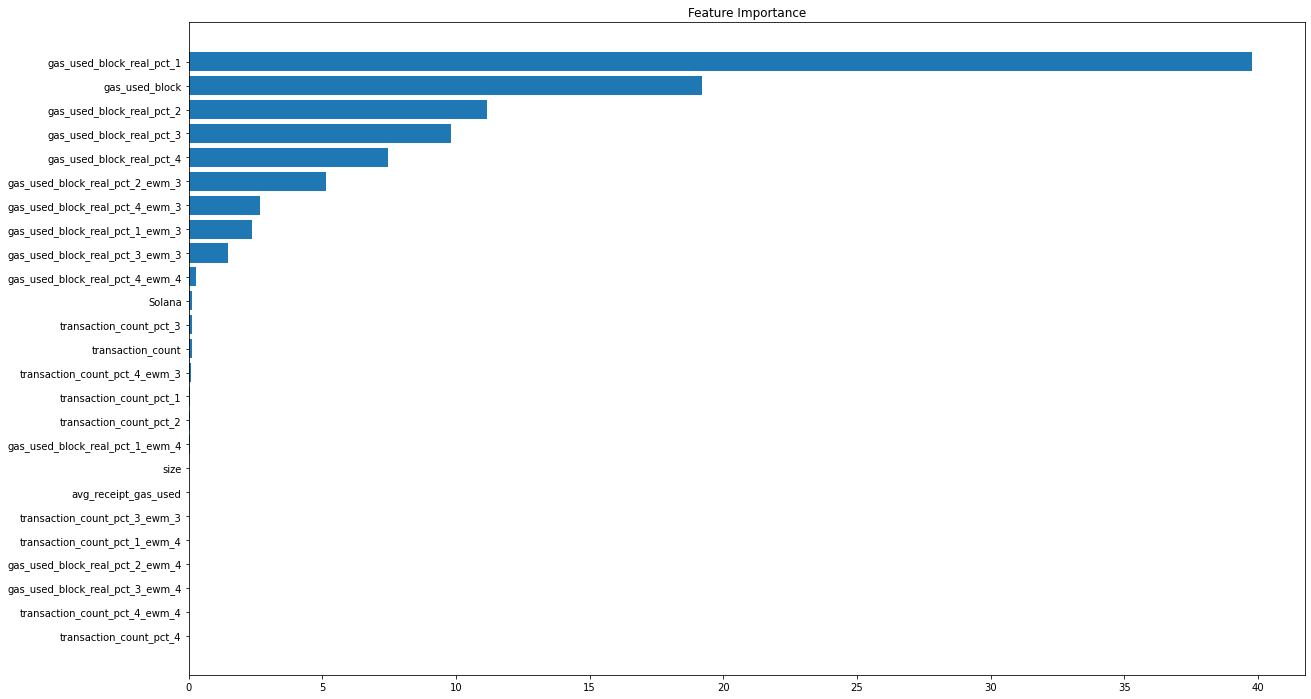

In [12]:

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

In [13]:
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.impute import KNNImputer

cbr_hyper_rmse_mape_r2_list = []

df = df_fe.copy().dropna(subset='gas_used_block_real')

start_time = time()
for d in [3,4,5,6]:
# for d in [3]:
    for cbr_iter in np.arange(100,410,50):
    # for cbr_iter in [150]:
        # print('########## working on cbr_iter %d ##########'%cbr_iter)
        for niter in range(5):
        # for niter in [0]:
            # tmp_time = time()
            print('----- working on d %d, cbr_iter %d, niter %d -----'%(d, cbr_iter, niter))
            oot = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=0+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=1+niter)))]
            tst = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=1+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=3+niter)))]
            trn = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=3+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=12+niter)))]

            x_trn = trn[vars_selected]
            x_tst = tst[vars_selected]
            x_oot = oot[vars_selected]

        ############################################################
            # preprocessing
            # winsorization
            trn_pctil_95 = x_trn[vars_selected].quantile(0.95)
            trn_pctil_10 = x_trn[vars_selected].quantile(0.1)

            x_tst = x_tst.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
            x_oot = x_oot.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
            x_trn = x_trn.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)

            # Normalization and standardize to [-1,1]
            x_tst = (x_tst - x_trn.mean()) / x_trn.std()
            x_tst = 2 * (x_tst - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

            x_oot = (x_oot - x_trn.mean()) / x_trn.std()
            x_oot = 2 * (x_oot - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

            x_trn = (x_trn - x_trn.mean()) / x_trn.std()
            x_trn = 2 * (x_trn - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

            # impute for missing values
            x_tst.fillna(x_trn.mean(),inplace=True)
            x_oot.fillna(x_trn.mean(),inplace=True)
            x_trn.fillna(x_trn.mean(),inplace=True)
            
            # print('working on knn imputer')
            # # KNN imputation is taking too much time, ignore for now
            # imputer = KNNImputer(n_neighbors=3)
            # imputer.fit(x_trn)
            
            # x_trn = imputer.transform(x_trn)
            # x_tst = imputer.transform(x_tst)
            # x_oot = imputer.transform(x_oot)
        ############################################################
            print('Preprocessing Finished')
            y_oot = oot['gas_used_block_real']
            y_tst = tst['gas_used_block_real']
            y_trn = trn['gas_used_block_real']

            cbr = CatBoostRegressor(verbose=0, depth=d, iterations=cbr_iter, learning_rate=0.01, l2_leaf_reg=5, random_seed=42)
            cbr.fit(x_trn, y_trn)

            cbr_predictions_trn = cbr.predict(x_trn)
            rmse_trn = np.sqrt(mean_squared_error(y_trn, cbr_predictions_trn))
            mape_trn = rmse_trn / np.mean(y_trn)

            cbr_predictions_tst = cbr.predict(x_tst)
            rmse_tst = np.sqrt(mean_squared_error(y_tst, cbr_predictions_tst))
            mape_tst = rmse_tst / np.mean(y_tst)

            cbr_predictions_oot = cbr.predict(x_oot)
            rmse_oot = np.sqrt(mean_squared_error(y_oot, cbr_predictions_oot))
            mape_oot = rmse_oot / np.mean(y_oot)

            cbr_hyper_rmse_mape_r2_list.append([cbr_iter, d, rmse_trn, rmse_tst, rmse_oot, mape_trn, mape_tst, mape_oot, cbr.score(x_trn, y_trn)])
            print('cbr finished')
            

----- working on d 3, cbr_iter 100, niter 0 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 100, niter 1 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 100, niter 2 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 100, niter 3 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 100, niter 4 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 150, niter 0 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 150, niter 1 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 150, niter 2 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 150, niter 3 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 150, niter 4 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 200, niter 0 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 200, niter 1 -----
Prep

In [14]:
cbr_hyper_rmse_mape_r2_list

[[100,
  3,
  3186524.7333003716,
  2756944.3403826845,
  2925137.430819885,
  0.21078988817801766,
  0.18256839684680368,
  0.19359781154564476,
  0.6501678820925461],
 [100,
  3,
  3261217.5017947173,
  2840324.7338479687,
  2836971.0484741204,
  0.21565540867585975,
  0.18803105373075324,
  0.18780681011800301,
  0.6488514664355709],
 [100,
  3,
  3343851.4825913883,
  3047860.420269606,
  2667415.3572501657,
  0.2210155869480075,
  0.20161309631092056,
  0.17669892504529225,
  0.6504001403875597],
 [100,
  3,
  3445191.095801118,
  2888095.52775977,
  3003344.896882111,
  0.227570956547123,
  0.19118321092481785,
  0.19869847409891353,
  0.6538165529867543],
 [100,
  3,
  3671270.9917669906,
  2913280.4546469944,
  3166598.854758494,
  0.24218227760789995,
  0.19291056330465525,
  0.20943474649040306,
  0.6552218764879472],
 [150,
  3,
  2646190.824290588,
  2399993.280934213,
  2530896.5788528793,
  0.17504658354626695,
  0.15893063901407584,
  0.16750530547788373,
  0.75874995102

In [15]:
cbr_hyper_rmse_mape_r2_df = pd.DataFrame(cbr_hyper_rmse_mape_r2_list, columns=['cbr_iter','d','trn_rmse','tst_rmse','oot_rmse','trn_mape','tst_mape','oot_mape','trn_r2'])
# cbr_hyper_rmse_r2_df.to_csv('block_level_cbr_hyper_rmse_r2_df.csv')

In [16]:
cbr_hyper_rmse_mape_r2_df.groupby(['cbr_iter', 'd']).mean()

trn_rmse      tst_rmse      oot_rmse  trn_mape  tst_mape  \
cbr_iter d                                                                 
100      3  3.381611e+06  2.889301e+06  2.919894e+06  0.223443  0.191261   
         4  3.182791e+06  2.823300e+06  2.845720e+06  0.210306  0.186892   
         5  3.030337e+06  2.849078e+06  2.864141e+06  0.200233  0.188600   
         6  2.919635e+06  2.920564e+06  2.937606e+06  0.192918  0.193331   
150      3  2.794548e+06  2.610275e+06  2.620690e+06  0.184653  0.172792   
         4  2.560696e+06  2.821637e+06  2.823961e+06  0.169201  0.186784   
         5  2.381853e+06  3.091663e+06  3.092269e+06  0.157384  0.204659   
         6  2.237395e+06  3.436113e+06  3.438360e+06  0.147838  0.227460   
200      3  2.395693e+06  2.716319e+06  2.713400e+06  0.158299  0.179813   
         4  2.151852e+06  3.234699e+06  3.225033e+06  0.142187  0.214128   
         5  1.952573e+06  3.718391e+06  3.710119e+06  0.129019  0.246147   
         6  1.808783e+06  4.162021e+06  4.156112e+06  0.119517  0.275514   
250      3  2.116902e+06  3.000076e+06  2.987204e+06  0.139877  0.198597   
         4  1.879516e+06  3.778105e+06  3.761390e+06  0.124192  0.250100   
         5  1.668108e+06  4.417798e+06  4.404944e+06  0.110222  0.292446   
         6  1.523498e+06  4.889515e+06  4.879493e+06  0.100667  0.323672   
300      3  1.932307e+06  3.327269e+06  3.308547e+06  0.127680  0.220256   
         4  1.697558e+06  4.280202e+06  4.259455e+06  0.112169  0.283338   
         5  1.493369e+06  4.948209e+06  4.933480e+06  0.098676  0.327558   
         6  1.349970e+06  5.420913e+06  5.410495e+06  0.089201  0.358849   
350      3  1.798524e+06  3.698494e+06  3.675377e+06  0.118840  0.244830   
         4  1.570771e+06  4.729134e+06  4.705859e+06  0.103792  0.313056   
         5  1.379262e+06  5.348206e+06  5.333171e+06  0.091136  0.354037   
         6  1.242842e+06  5.796151e+06  5.786576e+06  0.082122  0.383689   
400      3  1.692191e+06  4.093026e+06  4.067074e+06  0.111814  0.270947   
         4  1.471055e+06  5.156677e+06  5.132425e+06  0.097202  0.341358   
         5  1.298616e+06  5.659402e+06  5.645966e+06  0.085808  0.374638   
         6  1.170280e+06  6.067188e+06  6.059737e+06  0.077327  0.401631   

            oot_mape    trn_r2  
cbr_iter d                      
100      3  0.193247  0.651692  
         4  0.188338  0.691372  
         5  0.189557  0.720220  
         6  0.194420  0.740321  
150      3  0.173444  0.761994  
         4  0.186897  0.800125  
         5  0.204656  0.827083  
         6  0.227565  0.847494  
200      3  0.179580  0.825016  
         4  0.213443  0.858781  
         5  0.245549  0.883749  
         6  0.275070  0.900286  
250      3  0.197702  0.863355  
         4  0.248943  0.892226  
         5  0.291537  0.915168  
         6  0.322948  0.929265  
300      3  0.218970  0.886151  
         4  0.281908  0.912086  
         5  0.326519  0.932022  
         6  0.358093  0.944469  
350      3  0.243250  0.901373  
         4  0.311453  0.924712  
         5  0.352973  0.942005  
         6  0.382984  0.952940  
400      3  0.269175  0.912675  
         4  0.339686  0.933975  
         5  0.373675  0.948592  
         6  0.401063  0.958279

# (150,3) seems to be a great combination. Use this hyperparameter to get the final model

In [17]:
input_df = df[(df['datetime'] >= '2023-01-01 00:00:00') & (df['datetime'] < '2024-01-01 00:00:00')]
input_x = input_df[vars_selected]
input_y = input_df['gas_used_block_real']


In [18]:
# Preprocess
# Winsorization
pctil_95 = input_x.quantile(0.95)
pctil_10 = input_x.quantile(0.10)

input_x = input_x.clip(lower=pctil_10, upper=pctil_95, axis=1)

# Normalization and standardize to [-1,1]
input_x_mean = input_x.mean()
input_x_std = input_x.std()
input_x_max = input_x.max()
input_x_min = input_x.min()

input_x = (input_x - input_x.mean()) / input_x.std()
input_x = 2 * (input_x - input_x.min()) / (input_x.max() - input_x.min()) - 1

# fill na
fillna_mean = input_x.mean()
input_x.fillna(input_x.mean(),inplace=True)

In [19]:
cbr = CatBoostRegressor(verbose=0, depth=3, iterations=150, learning_rate=0.01, l2_leaf_reg=5, random_seed=42)
cbr.fit(input_x, input_y)


In [20]:
predict_x = df[df['datetime'] >= '2024-01-01 00:00:00'][vars_selected]
predict_x = predict_x.clip(lower=pctil_10, upper=pctil_95, axis=1)

predict_x = (predict_x - input_x_mean) / input_x_std
predict_x = 2 * (predict_x - input_x_min) / (input_x_max - input_x_min) - 1

# fill na
# predict_x.fillna(fillna_mean,inplace=True)

In [21]:
cbr.predict(predict_x)

array([20549588.172664  , 10469758.36392568, 12252433.87538024, ...,
       16996549.21185774, 17756072.64814427, 24700144.8749254 ])